# Error Analysis of Transformer for Sentiment Classification

In this notebook, we will analyze the errors made by our fine-tuned Transformer model on a sentiment classification task using a dataset of news headlines, tweets, etc and their associated sentiment labels.

The model contains the following improvement compared to the `ALBERT` training run:

- We've extended the dataset by adding more data sources.
    - The dataset is also further extended with data augmentation.
- Improved the labelling methodology so that the labels are more consistent.
- We now use a base model which is explicitly trained on uncased data.

Initially, we tested `distilbert-base-uncased`. It achieved much better accuracy than the `albert-large-v2` used in the first project iterations. However, upon evaluating various other models, we found that the [`xtremedistil-l12-h384-uncased`](https://huggingface.co/microsoft/xtremedistil-l12-h384-uncased) model achieved the same accuracy on the validation set, even though it's much smaller (0.5x) and faster (~1.5x). Therefore, in this notebook, we will analyze the errors made by the `xtremedistil-l12-h384-uncased` model.

In [1]:
# To allow importing modules from src
import sys
import os

# Get the absolute path of the 'src' directory
src_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add 'src' directory to the Python path
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

import torch
from torch.utils.data import DataLoader

from sklearn.metrics import classification_report

from transformers import AutoModelForSequenceClassification, AutoTokenizer, PreTrainedModel

from helpers import SentimentDataset, SENTIMENT_TO_ID, ID_TO_SENTIMENT, load_model, PlattScaling

### Load the pre-trained model and tokenizer

In [3]:
BATCH_SIZE = 100
MODEL_NAME = 'microsoft/xtremedistil-l12-h384-uncased'
TIME = '2023-05-18 12-36-04'

base_name = os.path.basename(MODEL_NAME)
model_path = f'../../models/{base_name}-sentiment {TIME}.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding="max_length", truncation=True)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=3, id2label=ID_TO_SENTIMENT, label2id=SENTIMENT_TO_ID
)

model = load_model(model, model_path, device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/xtremedistil-l12-h384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Load and preprocess the dataset

In [5]:
def collate_batch(batch, tokenizer, max_length=25):
    """Process a batch of data to its proper form."""
    # Feature should be batch_size * num_words * num_vocabs
    features, labels = zip(*batch)
    features = tokenizer(features, add_special_tokens=True, max_length=max_length, 
                         padding="max_length", truncation=True, return_tensors="pt")
    labels = torch.stack(labels)
    return features, labels

In [6]:
# Read the dataset
val_data = SentimentDataset('../../data/fixed-data/sentiment-val.csv')
test_data = SentimentDataset('../../data/fixed-data/sentiment-test.csv')

val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False,
                         collate_fn=lambda x: collate_batch(x, tokenizer))
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False,
                          collate_fn=lambda x: collate_batch(x, tokenizer))

## Evaluating the model

In [7]:
def get_predictions(model, data_loader, device='cpu'):
    """Get predictions from the model and targets on the data_loader."""
    model.eval()
    all_outputs = []
    all_targets = []
    for features, target in data_loader:
        features = features.to(device=device)
        target = target.to(device=device)
        
        # One-hot encode targets
        if isinstance(model, PreTrainedModel):
            output = model(**features, labels=target).logits
        else:
            output = model(features)
            if isinstance(output, tuple):
                output = output[0]
                
        target = torch.nn.functional.one_hot(target, num_classes=3)
        output = output.detach().to('cpu')
        target = target.detach().to('cpu')
        all_outputs.append(output)
        all_targets.append(target)

    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    return all_outputs, all_targets

output, target = get_predictions(model, val_loader, device=device)

In [8]:
def _classification_report(output, target):
    probs = torch.nn.functional.softmax(output, dim=1)
    preds = probs.argmax(dim=1)
    target = target.argmax(dim=1)
    report = classification_report(target, preds, output_dict=True, 
                                   target_names=ID_TO_SENTIMENT.values())
    report = pd.DataFrame(report)
    cols = ['Negative', 'Neutral', 'Positive', 'weighted avg']
    rows = ['precision', 'recall', 'f1-score']
    return report.loc[rows, cols].transpose()


def _baseline_accuracy(target):
    counter = target.sum(axis=0)
    counter = (counter/ counter.sum())
    
    baseline_acc = pd.DataFrame(counter, columns=['baseline accuracy'], index=ID_TO_SENTIMENT.values())
    baseline_acc.loc['weighted avg'] = counter.max().item()
    return baseline_acc


def compute_metrics(output, target):
    cls_report = _classification_report(output, target)
    baseline_accuracy = _baseline_accuracy(target)
    cls_report = pd.concat([baseline_accuracy, cls_report], axis=1)
    return cls_report

cls_report = compute_metrics(output, target)
cls_report

,baseline accuracy,precision,recall,f1-score
Negative,0.248317,0.951381,0.957721,0.954540
Neutral,0.472840,0.955615,0.950887,0.953245
Positive,0.278843,0.936518,0.938817,0.937666
weighted avg,0.472840,0.949238,0.949218,0.949223


### Analyze misclassified samples

In [9]:
def label_dataset_and_convert_to_df(dataset, output):
    df = _dataset_to_df(dataset)
    df['Predicted Sentiment'] = _map_prediction_to_sentiment_labels(output)
    return df

def _dataset_to_df(dataset):
    df = pd.DataFrame(tuple(dataset), columns=['Headlines', 'Sentiment'])
    df['Sentiment'] = df['Sentiment'].apply(lambda x: x.item())
    df['Sentiment'] = df['Sentiment'].map(ID_TO_SENTIMENT)
    return df

def _map_prediction_to_sentiment_labels(output):
    output = output.argmax(dim=1)
    output = pd.Series(output.numpy()).map(ID_TO_SENTIMENT)
    return output

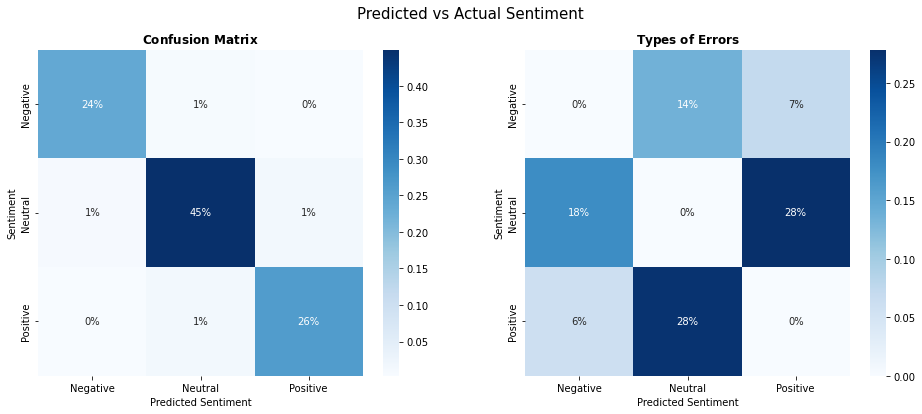

In [10]:
val_df = label_dataset_and_convert_to_df(val_data, output)
conf_mat = pd.crosstab(val_df['Sentiment'], val_df['Predicted Sentiment'])
error_rates = conf_mat.copy()
for i in range(len(error_rates)):
    error_rates.iloc[i,i] = 0

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(conf_mat / conf_mat.sum().sum(), ax=axes[0], annot=True, 
            fmt='.0%', cmap='Blues')
axes[0].set_title('$\\bf{Confusion\,\,Matrix}$')

sns.heatmap(error_rates / error_rates.sum().sum(), ax=axes[1], annot=True, 
            fmt='.0%', cmap='Blues')
axes[1].set_title('$\\bf{Types\,\,of\,\,Errors}$')

plt.suptitle('Predicted vs Actual Sentiment', fontsize=15, y=0.98)
plt.show()

In [11]:
disagree_df = val_df[val_df['Sentiment'] != val_df['Predicted Sentiment']].sample(8)
print('\033[1m' + 'Prediction Error headlines (Actual/Predicted Sentiment):' + '\033[0m')
for row in disagree_df.values.tolist():
    print(f'  ({row[1]}/{row[2]})\t"{row[0]}"')

Prediction Error headlines (Actual/Predicted Sentiment):
  (Neutral/Negative)	"ecb says forex benchmark rates compiled on too narrow basis"
  (Positive/Neutral)	"new nigerian officials signal shift in economic policy"
  (Negative/Neutral)	"were hedge funds illusioned with las vegas sands corp. lvs"
  (Positive/Neutral)	"charles river launches tailored portfolio solutions to power portfolio personalization at scale, integrates axioma portfolio optimizer"
  (Neutral/Positive)	"india is high on our priority since business links between our two countries is also expanding, tornstrom said"
  (Positive/Negative)	"gold eases from 3 week top as dollar holds steady"
  (Positive/Neutral)	"3 good buys in mlps"
  (Neutral/Positive)	"panasonic factory in kansas to create 8,000 jobs, governor says"


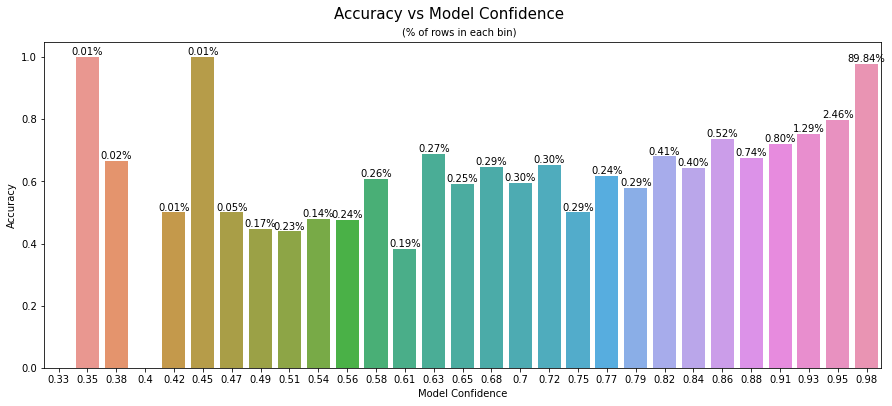

In [12]:
def plot_accuracy_vs_model_confidence(probs, target, title=None):
    confidence = np.max(probs, axis=1)
    target_labels = np.argmax(target.numpy(), axis=1)
    correct_preds = np.where(np.argmax(probs, axis=1) == target_labels, 1, 0)

    # Calculate error rate per confidence interval
    confidence_intervals = np.linspace(0.33, 1, 30)
    accuracy = []
    row_percentage = []
    for i in range(len(confidence_intervals) - 1):
        mask = (confidence >= confidence_intervals[i]) & (confidence < confidence_intervals[i + 1])
        if np.sum(mask) > 0:
            accuracy.append(np.mean(correct_preds[mask]))
            row_percentage.append(np.sum(mask) / len(confidence) * 100)
        else:
            accuracy.append(np.nan)
            row_percentage.append(0)

    # Plot error rate vs. model confidence
    plt.figure(figsize=(15, 6))
    ax = sns.barplot(x=np.round(confidence_intervals[:-1], 2), y=accuracy)

    # Annotate bars with the percentage of rows in each bin
    for i, p in enumerate(ax.patches):
        ax.annotate(
            f"{row_percentage[i]:.2f}%",
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha="center",
            va="bottom",
            fontsize=10,
        )

    plt.xlabel("Model Confidence")
    plt.ylabel("Accuracy")
    if title:
        plt.suptitle(title, fontsize=15, y=0.96)
    else:
        plt.suptitle("Accuracy vs Model Confidence", fontsize=15, y=0.96)
    plt.title("(% of rows in each bin)  ", fontsize=10)
    plt.show()

probs = torch.softmax(output, dim=1).numpy()
plot_accuracy_vs_model_confidence(probs, target)

Correlation coefficient: -0.05295837977738301


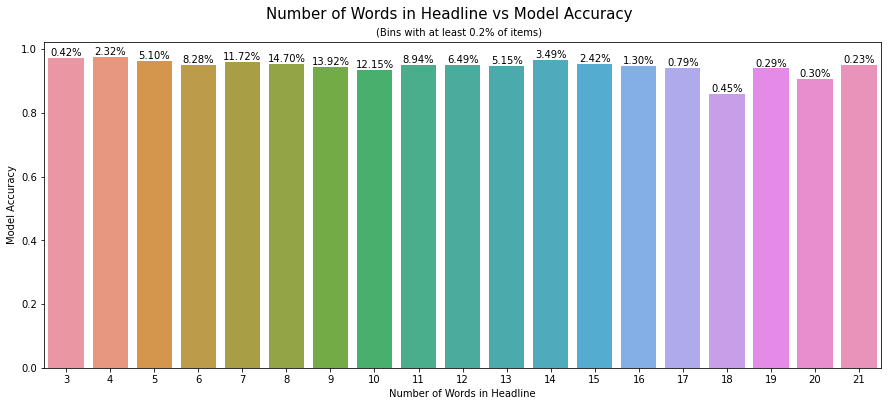

In [13]:
probs = torch.softmax(output, dim=1).numpy()
confidence = np.max(probs, axis=1)
target_labels = np.argmax(target.numpy(), axis=1)
correct_preds = np.where(np.argmax(probs, axis=1) == target_labels, 1, 0)

df = val_df.copy()
df['word_count'] = df['Headlines'].apply(lambda x: len(x.split()))
df['is_correct'] = (correct_preds).astype(int)

correlation, _ = scipy.stats.pearsonr(df['word_count'], df['is_correct'])
print(f'Correlation coefficient: {correlation}')

word_count_accuracy = df.groupby('word_count')['is_correct'].mean().reset_index()
# Calculate the percentage of rows for each word count bin
word_count_percentage = df.groupby('word_count')['is_correct'].count().reset_index()
word_count_percentage['percentage'] = (word_count_percentage['is_correct'] / df.shape[0]) * 100

# Merge accuracy and percentage data
word_count_data = pd.merge(word_count_accuracy, word_count_percentage, on='word_count', suffixes=('_accuracy', '_count'))
word_count_data_filtered = word_count_data[word_count_data['percentage'] >= 0.2]

# Create the bar plot
plt.figure(figsize=(15, 6))
ax = sns.barplot(x='word_count', y='is_correct_accuracy', data=word_count_data_filtered)
# Add annotations to the plot
for i, p in enumerate(ax.patches):
    percentage = word_count_data_filtered.iloc[i]['percentage']
    ax.annotate(
        f"{percentage:.2f}%",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom',
        fontsize=10,
    )

plt.xlabel('Number of Words in Headline')
plt.ylabel('Model Accuracy')
plt.suptitle('Number of Words in Headline vs Model Accuracy', fontsize=15, y=0.96)
plt.title('(Bins with at least 0.2% of items)  ', fontsize=10)
plt.show()


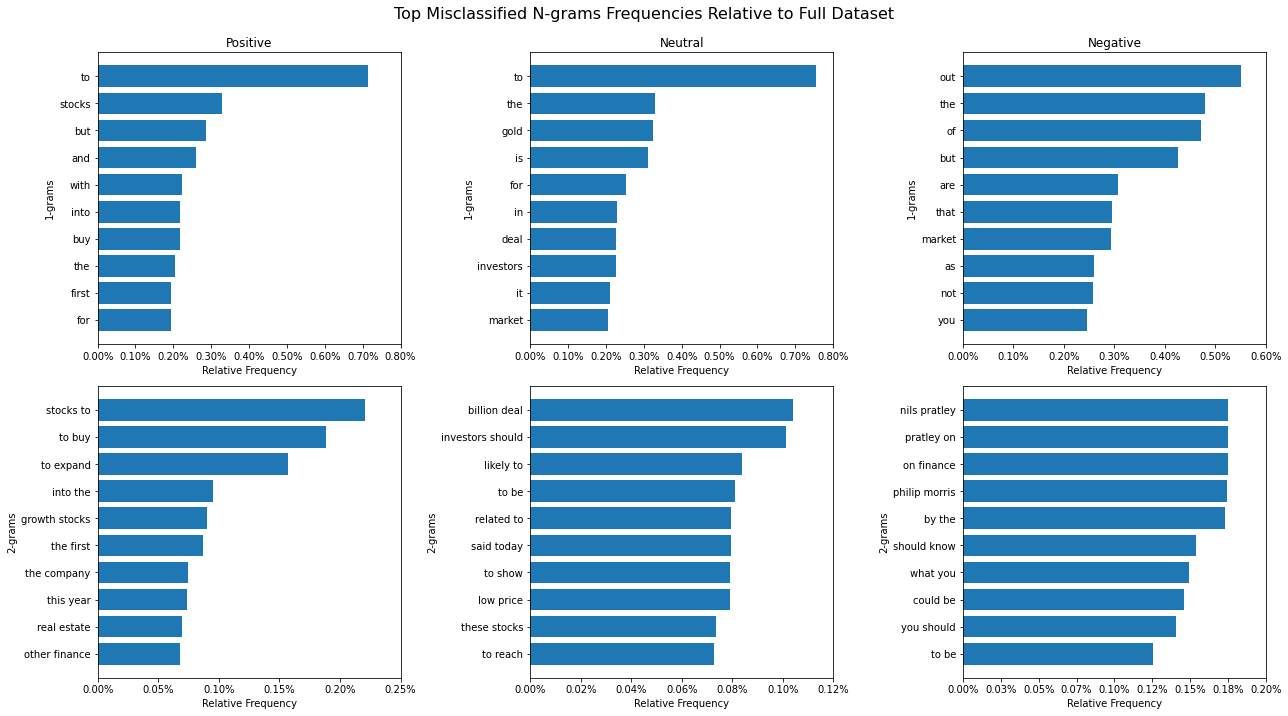

In [14]:
# Plot the distribution of word counts of misclassified samples vs. all samples for each sentiment
from sklearn.feature_extraction.text import CountVectorizer

def get_ngrams(corpus, ngrams=1, relative=False):
    """Get all n-grams from a corpus of text.
    
    Args:
        corpus: A list of strings representing the text documents.
        ngrams: The size of the n-grams to be extracted (default: 1).
        relative: If True, returns relative frequencies (default: False).
    
    Returns:
        A tuple containing two lists: n-gram words and their corresponding frequencies.
    """
    vec = CountVectorizer(ngram_range=(ngrams, ngrams)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    words, frequencies = zip(*words_freq)
    if relative:
        frequencies = frequencies / np.sum(frequencies)
    return words, frequencies

def plot_top_ngrams_relative(ax, corpus, total_counts, ngrams=1, top_k=10):
    """ Plot the top k n-grams relative to the total dataset for a given corpus.
    
    I.e. if 'bull' is 0.2% of the total dataset and 0.6% of the corpus, then the relative
    frequency of 'bull' is 0.6 - 0.2 = 0.4 %.
    
    Args:
        ax: A matplotlib axes object for plotting.
        corpus: A list of strings representing the text documents.
        total_counts: A dictionary containing the total counts of n-grams for all sentiments.
        ngrams: The size of the n-grams to be extracted (default: 1).
        top_k: The number of top n-grams to display (default: 10).
    """
    word_freq = get_ngrams(corpus, ngrams=ngrams, relative=True)
    relative_word_freq = [(w, f - total_counts[w]) for w, f in zip(*word_freq)]
    words_freq = sorted(relative_word_freq, key=lambda x: x[1], reverse=True)[:top_k]
    words, relative_frequencies = zip(*words_freq)

    ax.barh(words, relative_frequencies)
    ax.invert_yaxis()
    ax.set_xlabel('Relative Frequency')
    ax.set_ylabel(f'{ngrams}-grams')
    # Set x-axis to percentage
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    ax.set_xticklabels(['{:,.2%}'.format(x) for x in xticks])

total_1ngrams = get_ngrams(df['Headlines'], ngrams=1, relative=True)
total_1ngrams = dict(zip(*total_1ngrams))
total_2ngrams = get_ngrams(df['Headlines'], ngrams=2, relative=True)
total_2ngrams = dict(zip(*total_2ngrams))

unique_sentiments = ['Positive', 'Neutral', 'Negative']
num_sentiments = len(unique_sentiments)
fig, axes = plt.subplots(2, num_sentiments, figsize=(6 * num_sentiments, 10))

for col, sentiment in enumerate(unique_sentiments):
    mask = df['Sentiment'] == sentiment
    missclassified_headlines = df[mask & (df['is_correct'] == 0)]['Headlines']

    axes[0, col].set_title(sentiment)
    plot_top_ngrams_relative(axes[0, col], missclassified_headlines, total_counts=total_1ngrams, ngrams=1)
    plot_top_ngrams_relative(axes[1, col], missclassified_headlines, total_counts=total_2ngrams, ngrams=2)

fig.suptitle('Top Misclassified N-grams Frequencies Relative to Full Dataset', fontsize=16, y=0.99)
plt.tight_layout()
plt.show()

### Test Set Evaluation

Since the model achieved a validation accuracy of 95%, and no big problems were found in the error analysis, we will evaluate the model on the test set. This means that no further fine-tuning will be performed.

In [15]:
val_output, val_target = output, target  # Rename for clarity
test_output, test_target = get_predictions(model, test_loader, device=device)
print(compute_metrics(test_output, test_target))

              baseline accuracy  precision    recall  f1-score
Negative               0.248317   0.947585  0.951287  0.949432
Neutral                0.472897   0.952312  0.949324  0.950816
Positive               0.278786   0.933606  0.935325  0.934465
weighted avg           0.472897   0.945923  0.945909  0.945914


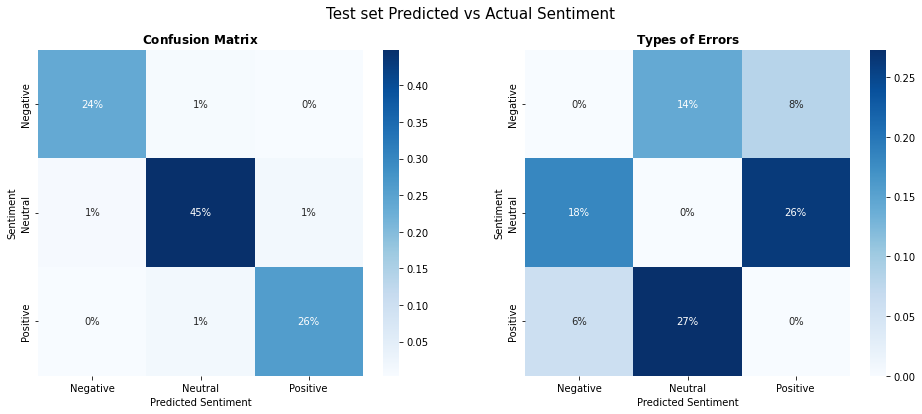

In [16]:
test_df = label_dataset_and_convert_to_df(test_data, test_output)
conf_mat = pd.crosstab(test_df['Sentiment'], test_df['Predicted Sentiment'])
error_rates = conf_mat.copy()
for i in range(len(error_rates)):
    error_rates.iloc[i,i] = 0

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(conf_mat / conf_mat.sum().sum(), ax=axes[0], annot=True, 
            fmt='.0%', cmap='Blues')
axes[0].set_title('$\\bf{Confusion\,\,Matrix}$')

sns.heatmap(error_rates / error_rates.sum().sum(), ax=axes[1], annot=True, 
            fmt='.0%', cmap='Blues')
axes[1].set_title('$\\bf{Types\,\,of\,\,Errors}$')

plt.suptitle('Test set Predicted vs Actual Sentiment', fontsize=15, y=0.98)
plt.show()

## Key Findings

- The model achieves an accuracy of roughly 95% on both the validation and test set.
- Most of the prediction errors are between the `Neutral` and `Positive` classes in both directions.
- On manual inspection of misclassified samples, we found that the model prediction was correct in many cases, and the labels were incorrect.
- There is no correlation between the length of a headline and prediction accuracy.
- Similarly, there is no discernible relationship between n-grams and prediction errors.
- The model appears to be badly calibrated, as prediction accuracy falls of a cliff as soon as model confidence is less than ~0.98.
    - We'll experiment with a fix for this in the next section.

Overall, the model performs well enough on the validationa and test set to be used in real-world applications.

### Earlier Findings
<span style="color: #999999">*This section contains the findings from an `albert-large-v2` model trained on an earlier version of the dataset.*</span>

- The model achieves an accuracy of roughly 80% on the validation set.
- The model appears to be overconfident, and its prediction accuracy decreases rapidly as the model's confidence deteriorates.
    - One potential solution is to implement label-smoothing during model training.
- The model faces challenges in predicting neutral sentiment.
    - To address this issue, two possible solutions are:
        - Retrain the model with a neutral default class.
        - Implement label smoothing to increase the likelihood of neutral predictions.
- There is no correlation between the length of a headline and prediction accuracy.
- There is no clear correlation between n-grams and prediction errors.

## Calibrating Model Prediction Probabilities

We're going to test Platt scaling with fitted logistic regression models to calibrate the model outputs. We will fit the model on the validation set and evaluate it on the test set.

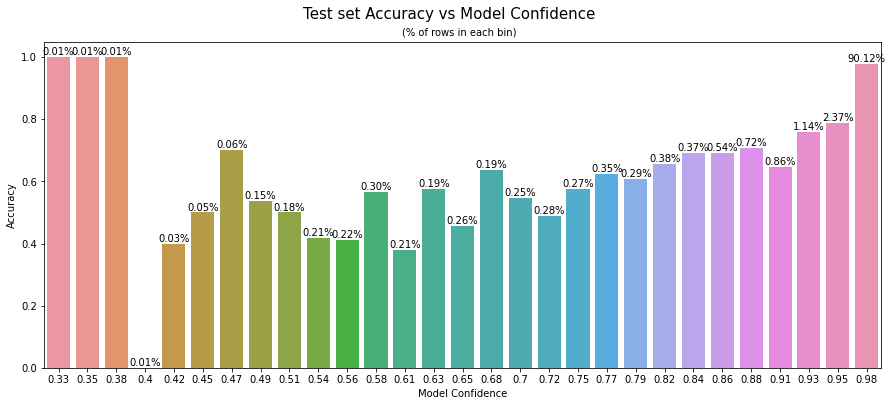

In [17]:
# First, let's evaluate the calibration of the model on the test set
test_probs = torch.softmax(test_output, dim=1).numpy()
plot_accuracy_vs_model_confidence(
    test_probs, test_target, title='Test set Accuracy vs Model Confidence'
)

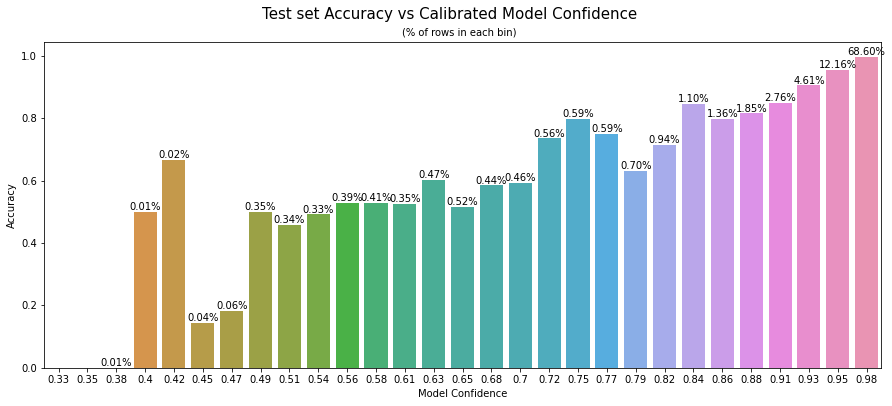

In [18]:
platt_scaler = PlattScaling()
platt_scaler.fit(val_output, val_target)
calibrated_probs = platt_scaler.transform(test_output).numpy()
plot_accuracy_vs_model_confidence(
    calibrated_probs, test_target, title='Test set Accuracy vs Calibrated Model Confidence'
)

Platt scaling improves the model's calibration significantly. A version trained on both validation and test set will be used in the final prediction pipeline.